In [1]:


# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile

# Qiskit IBM Provider
from qiskit_ibm_provider import IBMProvider, least_busy



In [2]:
provider = IBMProvider()
backend = least_busy(provider.backends(simulator=False, operational=True))
backend

<IBMBackend('ibm_kyoto')>

In [ ]:
# controls = QuantumRegister(2, name="control"): Esta linha cria um registrador quântico chamado "controls" com 2 qubits. Esse registrador será usado para armazenar os qubits de controle em um circuito quântico. O argumento name="control" é opcional e apenas define um nome para esse registrador.
# target = QuantumRegister(1, name="target"): Esta linha cria um registrador quântico chamado "target" com 1 qubit. Esse registrador será usado para armazenar o qubit de destino em um circuito quântico. O argumento name="target" é opcional e apenas define um nome para esse registrador.
# mid_measure = ClassicalRegister(2, name="mid"): Esta linha cria um registrador clássico chamado "mid_measure" com 2 bits clássicos. Este registrador será usado para armazenar os resultados de medições intermediárias em um circuito quântico. O argumento name="mid" é opcional e apenas define um nome para esse registrador.
# final_measure = ClassicalRegister(1, name="final"): Esta linha cria um registrador clássico chamado "final_measure" com 1 bit clássico. Este registrador será usado para armazenar o resultado final de medição em um circuito quântico. O argumento name="final" é opcional e apenas define um nome para esse registrador.
# circuit = QuantumCircuit(controls, target, mid_measure, final_measure): Esta linha cria um circuito quântico chamado "circuit" que consiste nos registradores quânticos controls e target e nos registradores clássicos mid_measure e final_measure. Em outras palavras, este circuito terá 3 qubits quânticos (2 no registrador controls e 1 no registrador target) e 3 bits clássicos (2 no registrador mid_measure e 1 no registrador final_measure). Este circuito pode ser usado para realizar operações quânticas e medições em qubits, bem como para armazenar os resultados de medições.

In [3]:
controls = QuantumRegister(2, name="control")
target = QuantumRegister(1, name="target")

mid_measure = ClassicalRegister(2, name="mid")
final_measure = ClassicalRegister(1, name="final")

circuit = QuantumCircuit(controls, target, mid_measure, final_measure)

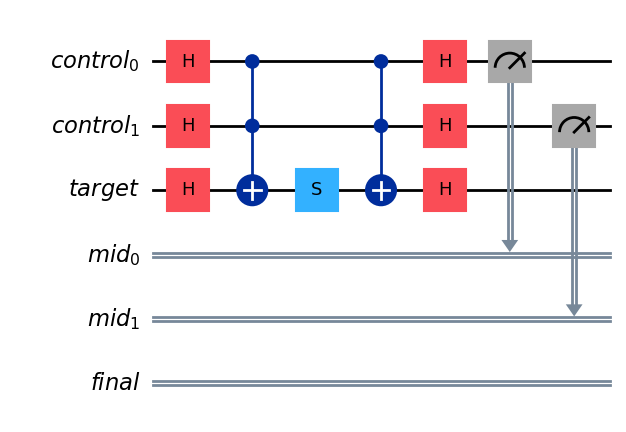

In [4]:
def trial(circuit, target, controls, measures):
    """Probabilistically perform an Rx gate for an
    angle that is an irrational multiple of pi."""
    circuit.h(target)
    circuit.h(controls)
    circuit.ccx(*controls, target)
    circuit.s(target)
    circuit.ccx(*controls, target)
    circuit.h(controls)
    circuit.h(target)
    circuit.measure(controls, measures)

trial(circuit, target, controls, mid_measure)
circuit.draw(output="mpl", style='iqp', cregbundle=False)

In [5]:
# Essencialmente, essa função é útil em certos casos em que os qubits de controle precisam ser redefinidos após uma operação ou medição. Ela garante que os qubits de controle voltem ao seu estado inicial, se necessário, antes de continuar com as operações subsequentes no circuito quântico.
def reset_controls(circuit, controls,  measures):
    """Reset the controlling qubits if they are in |1>."""
    with circuit.if_test((measures[0], True)):
        circuit.x(controls[0])
    with circuit.if_test((measures[1], True)):
        circuit.x(controls[1])

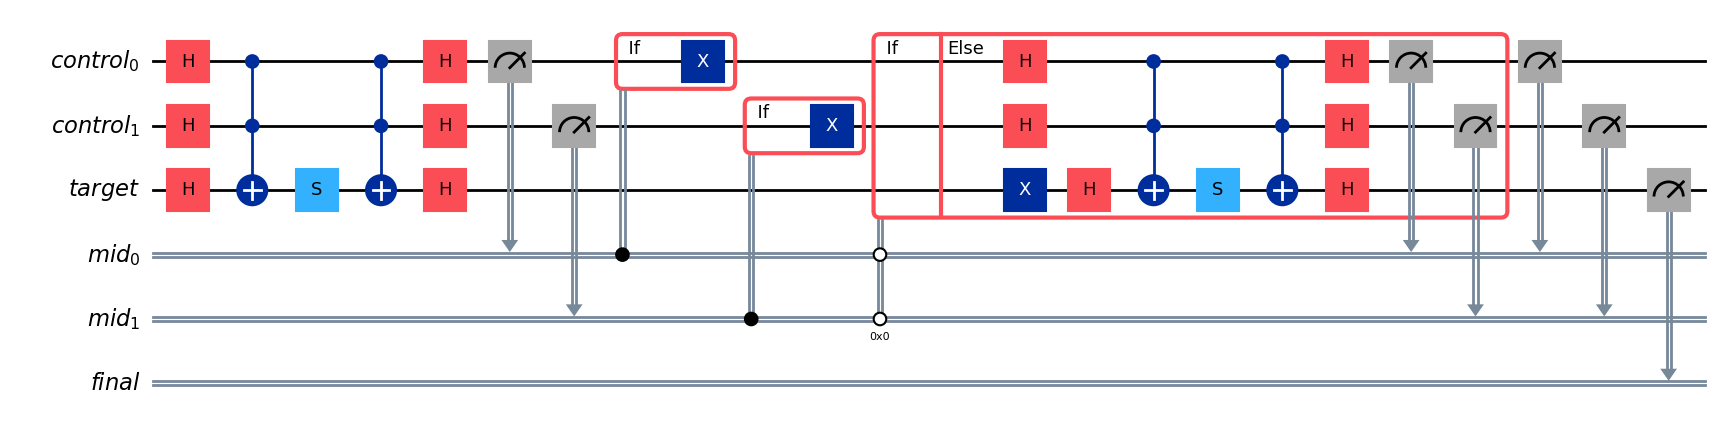

In [6]:
max_trials = 2

# Manually add the rest of the trials.  In the future, we will be
# able to use a dynamic `while` loop to do this, but for now, we
# statically add each loop iteration with a manual condition check
# on each one.  This involves more classical synchronizations than
# the while loop, but will suffice for now.
for _ in range(max_trials - 1):
    reset_controls(circuit, controls, mid_measure) #Chama a função reset_controls para redefinir os qubits de controle para o estado |0⟩, se necessário.
    with circuit.if_test((mid_measure, 0b00)) as else_:
        
        pass
    with else_:
       
        circuit.x(target)
        
        trial(circuit, target, controls, mid_measure)

# We need to measure the control qubits again to ensure we
# get their final results; this is a hardware limitation.
circuit.measure(controls, mid_measure)

# Finally, let's measure our target, to check that we're
# getting the rotation we desired.
circuit.measure(target, final_measure)

circuit.draw(output="mpl", style='iqp', cregbundle=False)



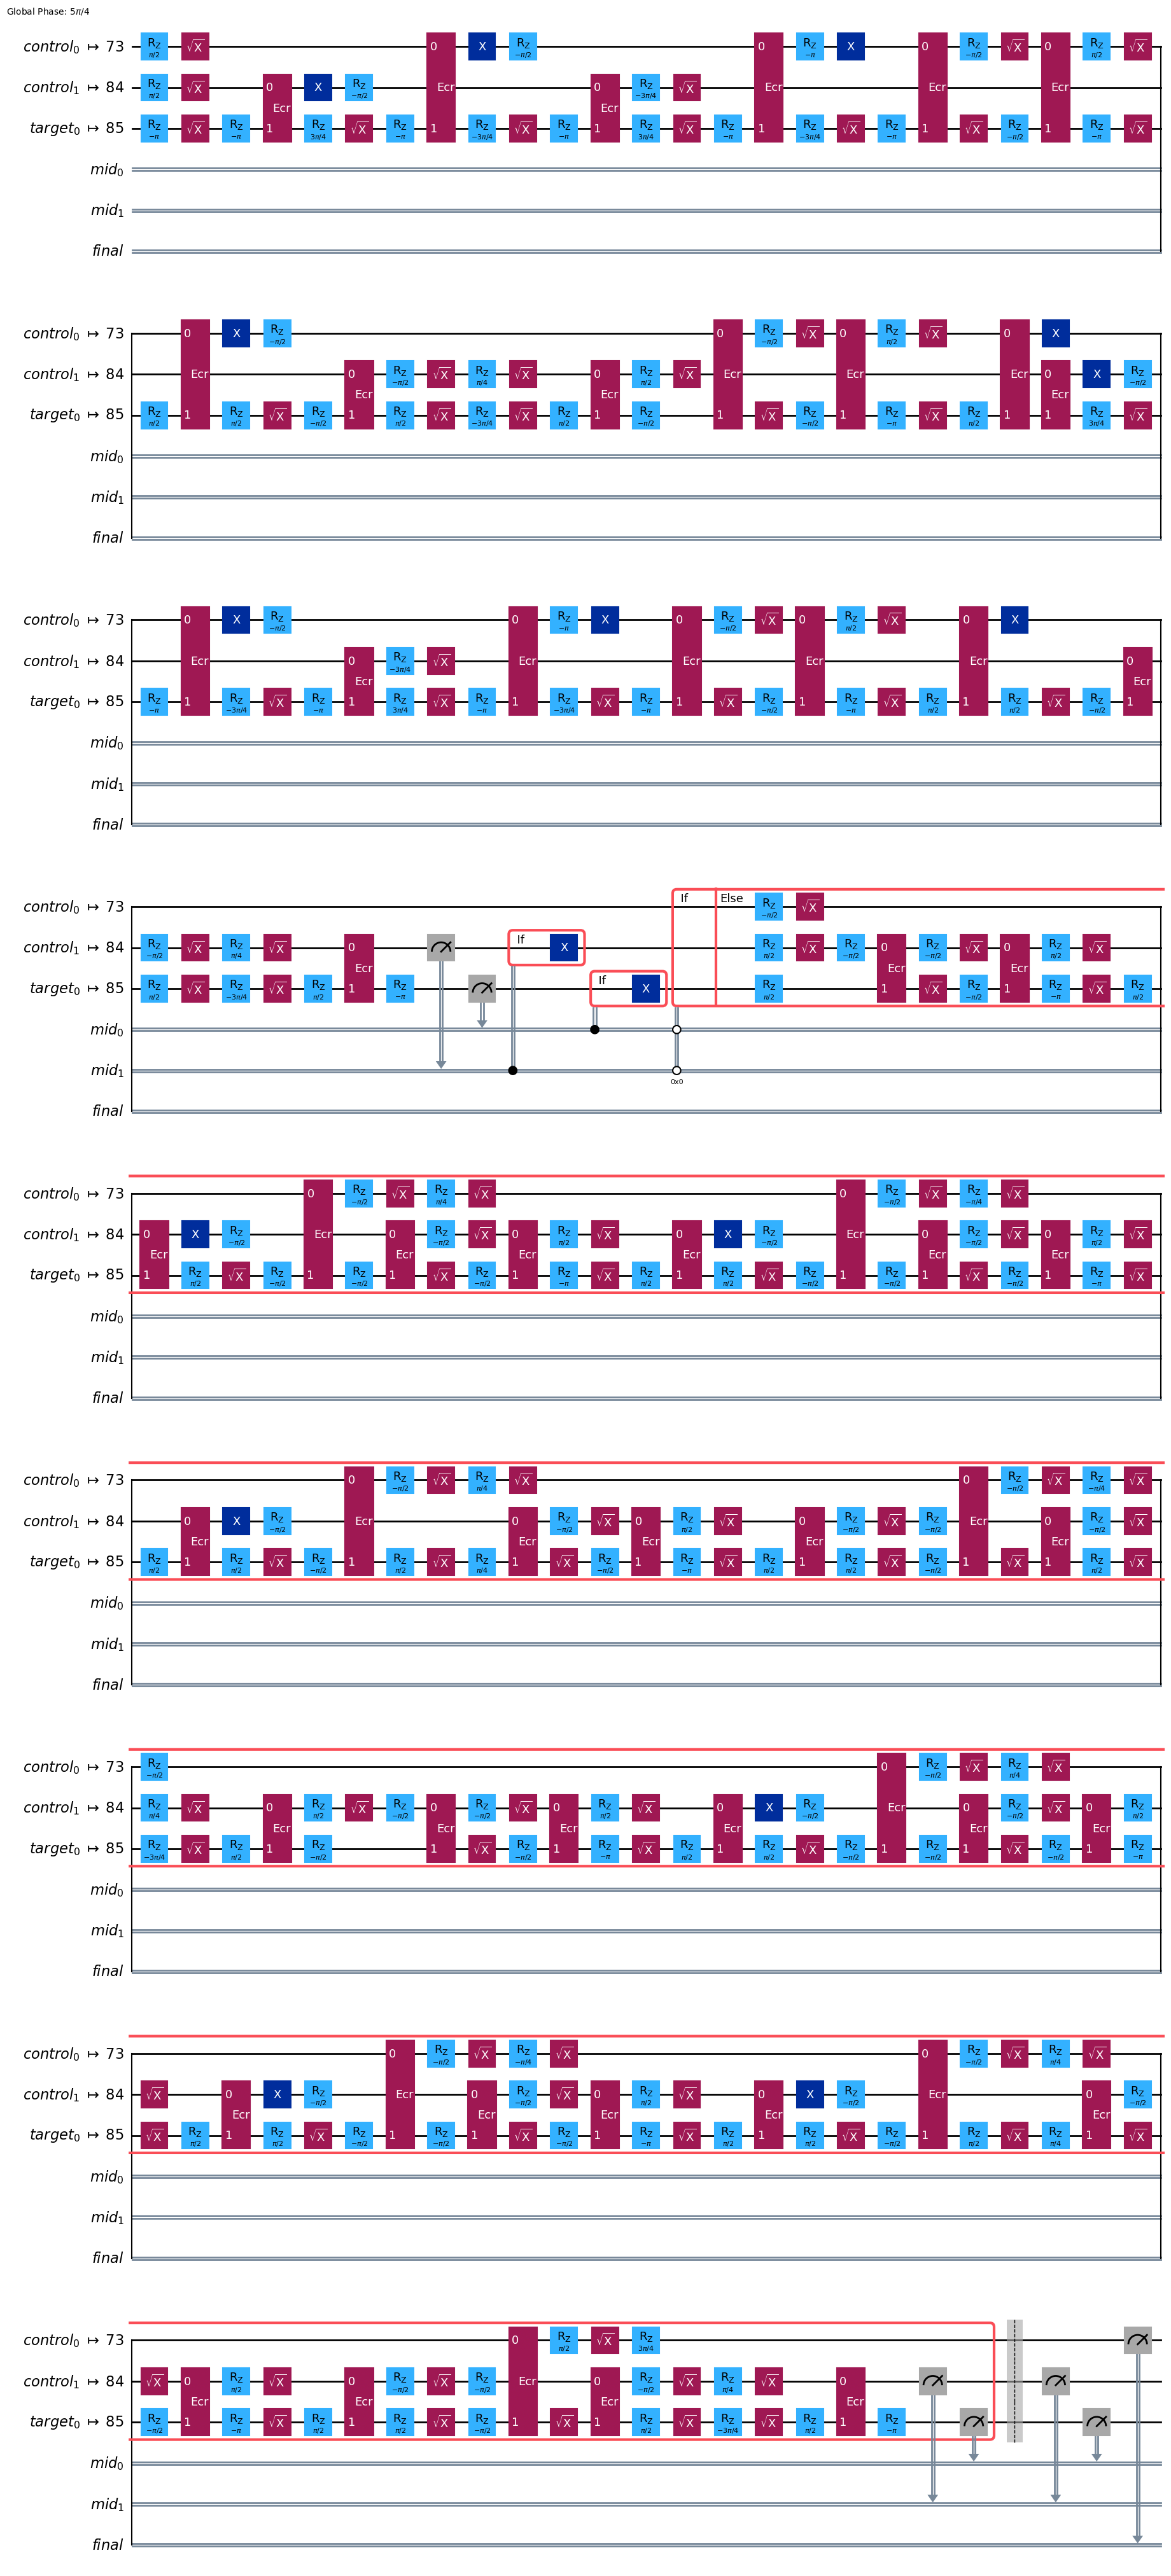

In [7]:
built = transpile(circuit, backend)
built.draw(output="mpl", style='iqp', idle_wires=False, cregbundle=False)

In [8]:
for ran_job in provider.backend.jobs(limit=5):
    
    print(f'{ran_job.job_id()} - date: {ran_job.creation_date().date()} - tags: {ran_job.tags()} - status: {ran_job.status()} ')

cqyeq54ae5gg008mn010 - date: 2024-03-21 - tags: [] - status: JobStatus.DONE 
cqxkdv7sayw0008907h0 - date: 2024-03-20 - tags: [] - status: JobStatus.DONE 
cqxk8y3qwzy0008kanv0 - date: 2024-03-20 - tags: [] - status: JobStatus.CANCELLED 
cqb9wnj45x80008bd1m0 - date: 2024-02-21 - tags: [] - status: JobStatus.ERROR 
cqb9q54tzeqg008ssgbg - date: 2024-02-21 - tags: [] - status: JobStatus.ERROR 


In [9]:
retrieved_job = provider.backend.retrieve_job("cqyeq54ae5gg008mn010")

retrieved_job


<IBMCircuitJob('cqyeq54ae5gg008mn010')>

In [10]:
retrieved_job.backend()

<IBMBackend('ibm_brisbane')>

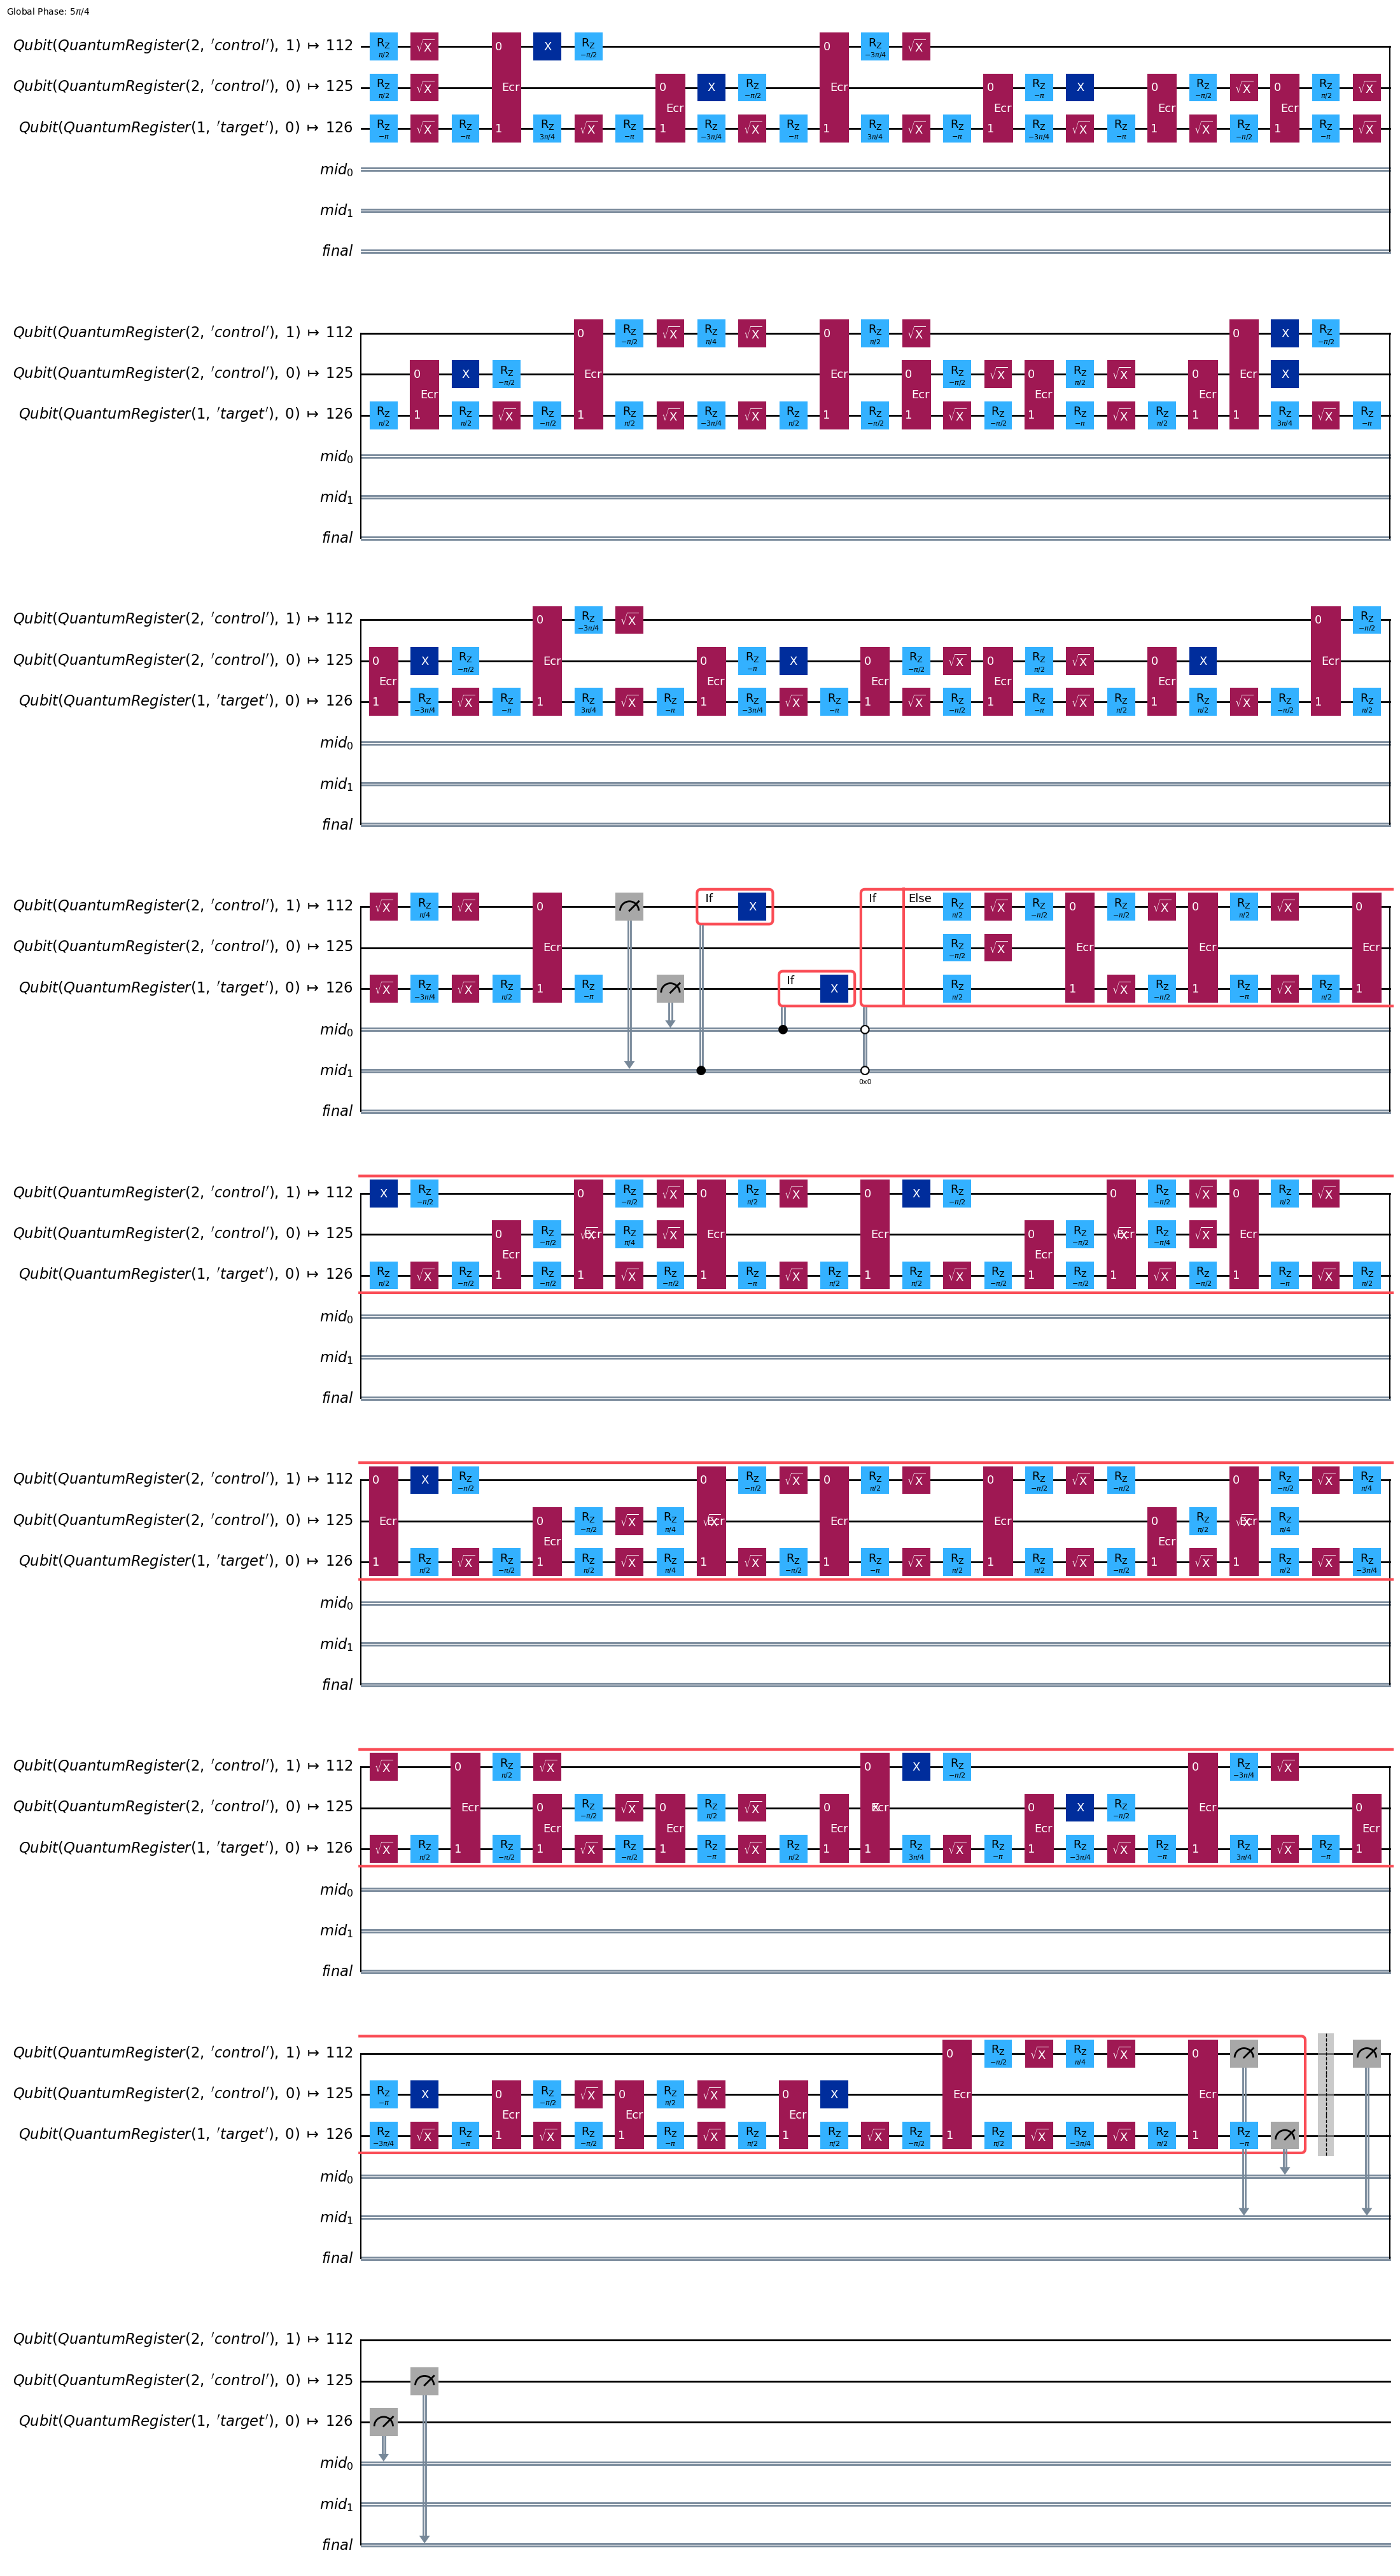

In [13]:
retrieved_job.circuits()[0].draw("mpl", style="iqp", idle_wires=False,cregbundle=False)

In [14]:
retrieved_job.result().get_counts()

{'0 00': 1689,
 '0 01': 199,
 '0 10': 200,
 '0 11': 159,
 '1 00': 989,
 '1 01': 260,
 '1 10': 259,
 '1 11': 245}

In [9]:
#Aqui eu tinha rodado antes 
job = backend.run(built,dynamic=True)


In [16]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [15]:
job.job_id()

'cqyeq54ae5gg008mn010'

In [15]:

import collections

def marginalize_successes(counts):
    """Split the full output `counts` dictionary
    into two separate dictionaries, marginalizing
    the results to leave only the target qubit's
    state."""
    successes = collections.defaultdict(int)
    failures = collections.defaultdict(int)
    
    for key, value in counts.items():
        if key.endswith("00"):
            successes[key[0]] += value
        else:
            failures[key[0]] += value
            
    return successes, failures

